CLARA Clustering multiprocessing

2025-01-10 14:50:40,180	INFO worker.py:1821 -- Started a local Ray instance.


Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   float64
 11  PURCHASES_TRX                     8950 

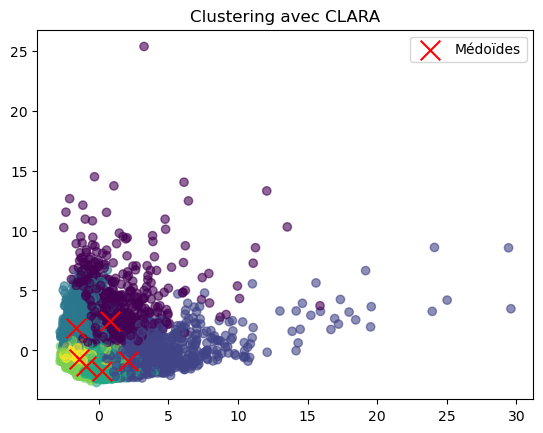

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_extra.cluster import CLARA
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score,silhouette_score,davies_bouldin_score,calinski_harabasz_score
import ray
import time

#Initiation du framework Ray pour gerer les taches paralleles
ray.init(ignore_reinit_error=True)

#Chargement et preparation du dataset
def load_and_prepare_data():
    data = pd.read_csv('credit_cards.csv') #Chargement du fichier CSV
    data.drop(columns=['CUST_ID'], inplace=True)  #Suppression de la colonnes d'identifiant inutile
    data.fillna(data.median(), inplace=True)  #Remplacement des valeurs manquantes par la mediane
    numeric_data = data.select_dtypes(include=[np.number])  #Selection des colonnes numeriques uniquement
    return (numeric_data - numeric_data.mean()) / numeric_data.std() #Normalisation du data

#Affichage des informations du dataset
def dataset_info(data):
    print("Informations sur le dataset :")
    print(data.info()) 
    print("\nStatistiques descriptives :")
    print(data.describe())

#Appliquation de l'algorithme CLARA Clustering
@ray.remote #transforme la fonction apply_clara en une tache qui peut etre excecutee en parallle
def apply_clara(data, k, sampling_size, random_state):
    clara = CLARA(n_clusters=k, n_sampling=sampling_size, random_state=random_state)
    labels = clara.fit_predict(data)#Effectuer le Clustering 
    return clara, labels

#Metriques d'evaluation
def evaluate_clustering(data, labels):
    print("\nMetriques d'evaluation :")
    #Usupervised
    silhouette = silhouette_score(data, labels)
    db_index = davies_bouldin_score(data, labels)
    ch_score = calinski_harabasz_score(data, labels)

    print(f"Silhouette Coefficient : {silhouette:.4f}")
    print(f"Davies-Bouldin Index : {db_index:.4f}")
    print(f"Calinski-Harabasz Index : {ch_score:.4f}")
    
    #Supervised (on n'a pas des labels deja classifier/Clustered)
    true_labels = None  
    if true_labels is not None:
        ari = adjusted_rand_score(true_labels, labels)
        nmi = normalized_mutual_info_score(true_labels, labels)
        print(f"Adjusted Rand Index (ARI) : {ari:.4f}")
        print(f"Normalized Mutual Information (NMI) : {nmi:.4f}")

def main():
    #Chargement des donnees
    data = load_and_prepare_data()
    dataset_info(data)

    #Nombre de clusters and samples
    k = 6  
    sampling_size = max(int(0.05 * len(data)), k + 1)  #Taille des sous-echantillons(samples)
    random_states = [42, 43, 44, 45]  #random_states pour que a chaque fois on execute le code, le meme splitting du dataset se genere ne change pas

    print(f"\nEtude avec sampling_size = {sampling_size}")
    #Chronometrer l'exécution
    start_time = time.time()

    #Creation des taches paralleles pour Ray, chaque tache s'excecute avec un state different
    tasks = [apply_clara.remote(data, k, sampling_size, state) for state in random_states]

    #Execution des taches en parallele avec Ray
    results = ray.get(tasks)

    end_time = time.time()
    print(f"Temps d'execution: {end_time - start_time:.2f} seconds")
    print(f"Nombre total d'echantillons generated : {sampling_size * len(random_states)}")

    #Selection du premier resultat retourner par les taches parallele
    best_clara, labels = results[0]

    #Extraction des medoides
    best_medoids = data.iloc[best_clara.medoid_indices_]

    #Evaluation des clusters
    evaluate_clustering(data, labels)

    #Visualization
    #Reduction des dimenssions a 2D
    pca = PCA(n_components=2) 
    reduced_data = pca.fit_transform(data)
    cluster_centers = pca.transform(best_medoids)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='red', marker='x', s=200, label='Médoïdes')
    plt.title("Clustering avec CLARA")
    plt.legend()
    plt.show()

    ray.shutdown()

if __name__ == "__main__":
    main()
